# Information de notebook

# I - Importations

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import recommender
import prepare_files
import importlib

importlib.reload(recommender)
importlib.reload(prepare_files)

<module 'prepare_files' from 'd:\\Formations\\Github\\Projet_10\\prepare_files.py'>

# Constantes

In [2]:
DATASETS_PATH = "datasets/"
ARTICLES_EMBEDDINGS_PATH = DATASETS_PATH + "articles_embeddings.pickle"
ARTICLES_METADATA_PATH = DATASETS_PATH + "articles_metadata.csv"
CLICKS_PATH = DATASETS_PATH + "clicks/"
CLICKS_HOUR_CONCATENATED_PATH = DATASETS_PATH + "clicks_hour_concatenated.csv"
PCA_REDUCTED_ARTICLES_EMBEDDINGS_PATH = DATASETS_PATH + "pca_reducted_articles_embeddings.pickle"
SVDS_PATH = DATASETS_PATH + "svds.pickle"
CLICKS_ESSENTIALS_INFORMATIONS_PATH = DATASETS_PATH + "clicks_essentials_informations.pickle"
MOST_POPULAR_ARTICLES_PATH = DATASETS_PATH + "most_popular_articles.pickle"

# Fonctions

In [3]:
def perc_fill_rate(datas: pd.DataFrame)-> float:
    """Calculer le taux de remplissage
    
    Parameters:
    datas: Dataframe dont le taux de remplissage est à calculer

    Returns:
    float: taux de remplissage calculé
    """

    return 100 - datas.isna().sum() / len(datas) * 100

def make_title(texte:str):
    """Ecrit tout simplement un ###### texte #####
    Cette fonction a été crée pour éviter de répéter les mêmes écritures de print

    Parameters:
    texte -- Texte à afficher
    """

    print("\n###### " + texte + " ######\n")

def make_plot_dtypes(datas:pd.DataFrame):
    """Crée un camembert de répartition de types utilisés de la dataframe
    
    Parameters:
    datas: Dataframe dont on veut calculer la répartition des types utilisées
    """

    print(datas.dtypes.value_counts())
    plt.figure(figsize=(10,5))
    plt.pie(datas.dtypes.value_counts().values,autopct="%1.2f%%",labels=[str(types) for types in datas.dtypes.value_counts().index])
    plt.title("Répartition des types dans le jeu de données.")
    plt.ylabel("Type des données")
    plt.legend()
    plt.show()

def make_perc_missing_values_info(datas:pd.DataFrame, perc_missing_values_threshold: int = 50) -> sns.barplot:
    """Fonction qui affiche un diagramme en barres contenant le taux de remplissage pour chaque variable de la dataframe
    
    Parameters:
    datas: Dataframe dont on désire afficher le taux de remplissage sous forme d'un diagramme en barres
    perc_missing_values_threshold: Le seuil du pourcentage qui indique si une variable est exploitable ou non (par défaut : 50)
    
    Returns:
    sns.barplot: contient l'objet de barplot
    """

    # Calcul du taux de remplissage
    perc_fill_rate_datas = perc_fill_rate(datas)
    perc_fill_rate_datas = perc_fill_rate_datas.sort_values(ascending=False)

    # Définition de la palette de couleurs en fonction du taux de remplissage
    palette = ["red" if p < perc_missing_values_threshold else "orange" if p < 100 else "green" for p in perc_fill_rate_datas.values]

    # Création d'un grpahique à barres pour le taux de remplissage
    plt.figure(figsize=(25,5))
    sns.barplot(x=perc_fill_rate_datas.index, y=perc_fill_rate_datas.values, hue=perc_fill_rate_datas.index, palette=palette)
    plt.ylabel("Taux de remplissage")
    plt.xlabel("Variables")
    plt.xticks(rotation=90)
    plt.title("Taux de remplissage du fichier")

    # Mise en place d'une ligne rouge marquant le seuil décidé %
    line_seuil = plt.axhline(y=perc_missing_values_threshold, color="red", linestyle="--", label="seuil " + str(perc_missing_values_threshold) + "%")

    # Création et paramétrage des légendes à afficher
    red_patch = mpatches.Patch(color="red", label="< " + str(perc_missing_values_threshold) + "%")
    orange_patch = mpatches.Patch(color="orange", label= "" + str(perc_missing_values_threshold) + "-]100%")
    green_patch = mpatches.Patch(color='green', label='100%')
    plt.legend(handles=[line_seuil, red_patch, orange_patch, green_patch], title='Taux de remplissage', loc='upper right')
    plt.show()

    # Afficher une dataframe sur le taux de remplissage des variables
    var_with_missing_values = perc_fill_rate_datas.loc[perc_fill_rate_datas < 100].to_frame()
    var_with_missing_values = var_with_missing_values.reset_index()
    var_with_missing_values = var_with_missing_values.rename(columns={"index": "Variable", 0: "% Taux remplissage"})

    if len(var_with_missing_values > 0):
        display(var_with_missing_values)

def analyse_outlier(df: pd.DataFrame):
    """Analyse affiche un boxplot de chaque variable numérique afin d'analyser les outliers
    
    Parameters:
    df: la dataframe dont on veut analyser les outliers
    """

    # Ne sélectionner que les variables numériques
    quantitatives = df.select_dtypes(include=["number"])

    make_title("Statistiques descriptives")
    display(quantitatives.describe())

    # Afficher les boxplots de chaque variable
    nb_var = len(quantitatives.columns)
    nb_cols = 5
    nb_rows = int(nb_var/nb_cols) + 1
    fig, axes = plt.subplots(nb_rows, nb_cols, figsize=(25, nb_rows * 5))
    for i, var in enumerate(quantitatives.columns):
        if nb_rows > 1:
            ax = axes[i // nb_cols, i % nb_cols]
        else:
            ax = axes[i // nb_cols]
        sns.boxplot(x=quantitatives[var], ax=ax)

    # Supprime les emplacements non utilisés
    for i in range(nb_var, nb_rows * nb_cols):
        fig.delaxes(axes.flatten()[i])

    make_title("Boxplots des variables")
    plt.show()
    
def analyse_exploratoire_generique(datas: pd.DataFrame, perc_missing_values_threshold: int = 50, nb_index: int = 1, enable_analyse_outlier: bool = True):
    """Effectue une analyse exploratoire générique

    Parameters:
    datas: la dataframe sur laquelle on veut effectuer une analyse exploratoire générique
    perc_missing_values_threshold: Le seuil du pourcentage de valeur manquant qui indique si une variable est exploitable ou non (par défaut: 50)
    nb_index: index de début d'analyse de doublons, utilisé pour analyser les doublons en dehors des index
    """

    # Présenter les informations générales
    make_title("Informations générales")
    datas.info()

    # Afficher la répartition des types dans le jeu de données
    make_title("Répartition des types dans le dataset")
    make_plot_dtypes(datas)


    # Afficher les 5 premières et derniè_res lignes du DataFrame
    make_title("Les 5 premières et dernières lignes")
    head = datas.head()
    tail = datas.tail()
    display(head, tail)

    # Afficher le nombre de valeurs uniques
    make_title("Nombre de valeurs uniques")
    display(datas.nunique().to_frame().T)

    # Afficher le nombre des doublons génériques
    make_title("Doublons génériques (toutes les variables sont utilisées)")
    display(datas.duplicated().sum())

    # Afficher le nombre des doublons sans l'index
    make_title("Doublons sans l'index")
    display(datas[datas.columns[nb_index:]].duplicated().sum())

    # Afficher les informations sur le taux de remplissage 
    make_title("Informations du taux de remplissage")
    make_perc_missing_values_info(datas, perc_missing_values_threshold)

    if enable_analyse_outlier:
        # Afficher les analyses des variables numériques 
        analyse_outlier(datas)

# Corps

## Lecture des datasets

In [5]:
df_articles = pd.read_csv(ARTICLES_METADATA_PATH)

In [6]:
if os.path.isfile(CLICKS_HOUR_CONCATENATED_PATH):
    df_clicks_hour = pd.read_csv(CLICKS_HOUR_CONCATENATED_PATH)
else:
    df_clicks_hour = pd.DataFrame()

    clicks_hour_files = os.listdir(CLICKS_PATH)
    for file in clicks_hour_files:
        df_clicks_hour = pd.concat([df_clicks_hour, pd.read_csv(CLICKS_PATH + file)], ignore_index=True)
    
    df_clicks_hour.to_csv(CLICKS_HOUR_CONCATENATED_PATH, index=False)

In [7]:
with open(ARTICLES_EMBEDDINGS_PATH, "rb") as f:
    df_embedding_articles = pd.DataFrame(pickle.load(f))

## Fusion des datasets

Comme le dataset sur l'interaction utilisateur-article sont séparés en plusieurs datasets, 1 dataset pour une heure.
Il est donc nécessaire de les fusionner en un seul dataset afin de pouvoir une analyse correcte.

In [8]:
df_full = df_clicks_hour.merge(df_articles, how="inner", left_on="click_article_id", right_on="article_id")
df_full.drop(columns="article_id", inplace=True)
df_full.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,281,1506800518000,0,280
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,136,1506816482000,0,226
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,375,1506807839000,0,159
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,209,1506788025000,0,206
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,247,1506784316000,0,239


## Analyse exploratoire générique

Il s'agit d'une analyse exploratoire générique en utilisant une fonction non personnalisée (c'est à dire que la fonction n'est pas faite sur mesure pour les datasets du projet), le résultat des analyses ne sont pas toujours pertinentes, mais certain peut apporter des informations intéressantes.

### Articles


###### Informations générales ######

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB

###### Répartition des types dans le dataset ######

int64    5
Name: count, dtype: int64


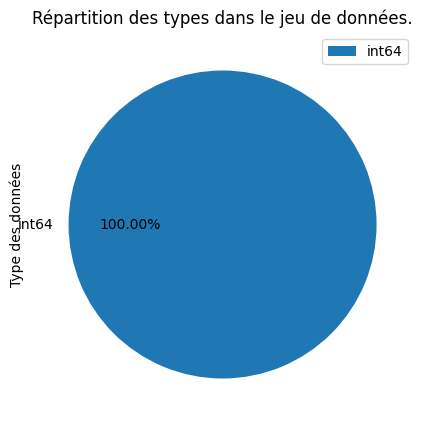


###### Les 5 premières et dernières lignes ######



,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


,article_id,category_id,created_at_ts,publisher_id,words_count
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126
364046,364046,460,1505811330000,0,479



###### Nombre de valeurs uniques ######



,article_id,category_id,created_at_ts,publisher_id,words_count
0,364047,461,359552,1,866



###### Doublons génériques (toutes les variables sont utilisées) ######



np.int64(0)


###### Doublons sans l'index ######



np.int64(6)


###### Informations du taux de remplissage ######



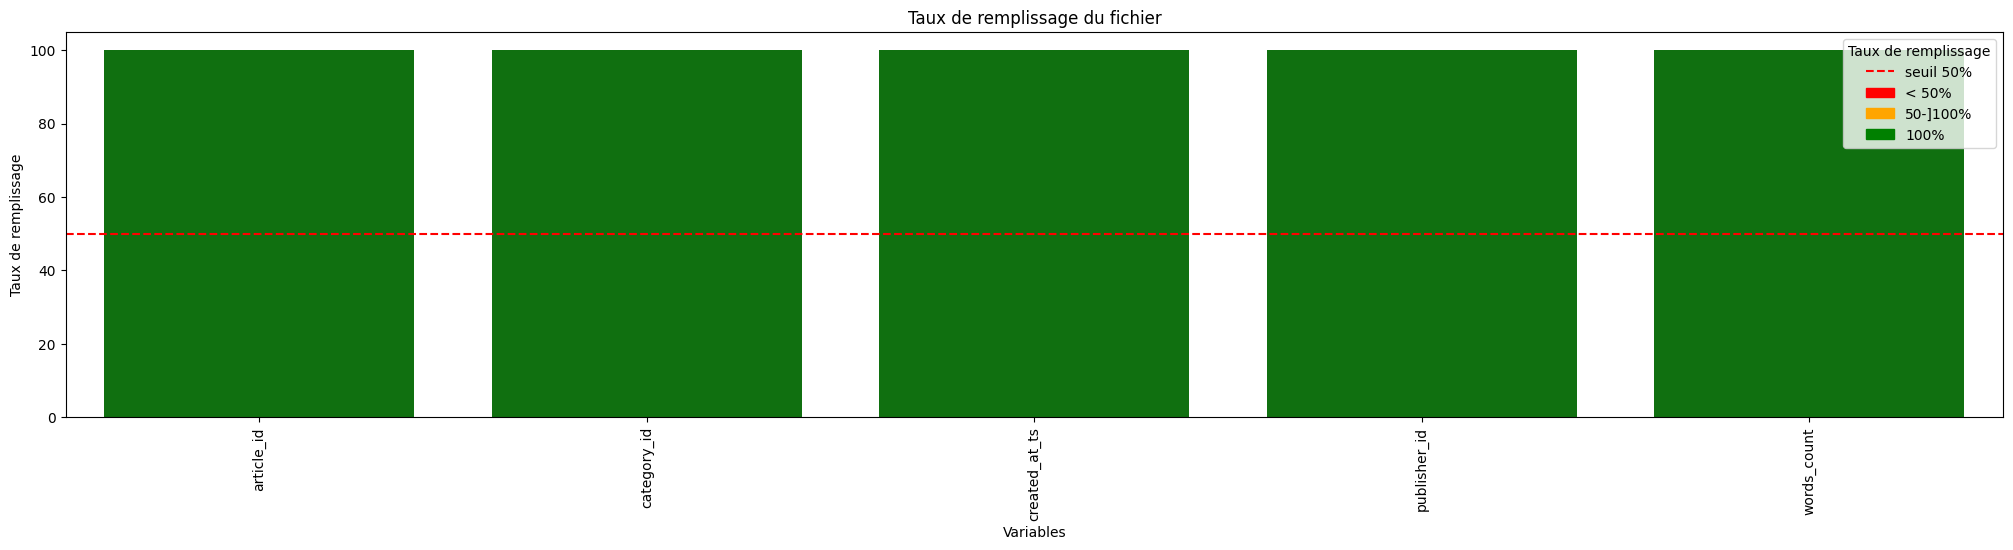


###### Statistiques descriptives ######



,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000



###### Boxplots des variables ######



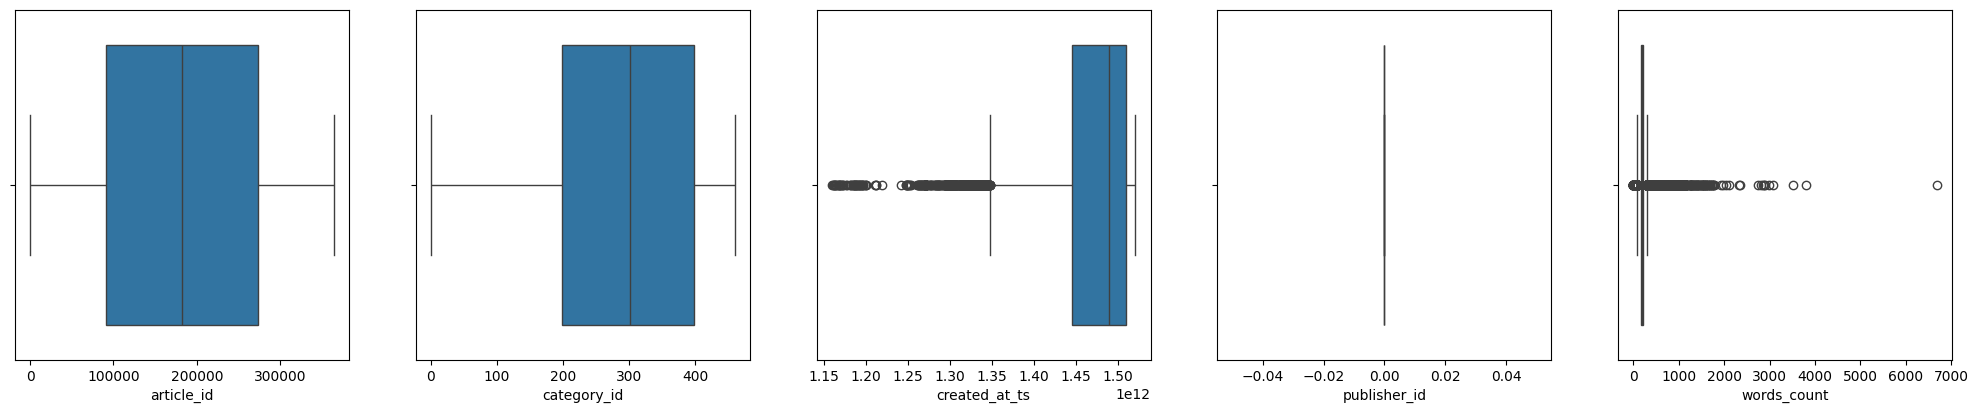

In [9]:
analyse_exploratoire_generique(df_articles)

### Clicks_hour


###### Informations générales ######

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype
---  ------               -----
 0   user_id              int64
 1   session_id           int64
 2   session_start        int64
 3   session_size         int64
 4   click_article_id     int64
 5   click_timestamp      int64
 6   click_environment    int64
 7   click_deviceGroup    int64
 8   click_os             int64
 9   click_country        int64
 10  click_region         int64
 11  click_referrer_type  int64
dtypes: int64(12)
memory usage: 273.6 MB

###### Répartition des types dans le dataset ######

int64    12
Name: count, dtype: int64


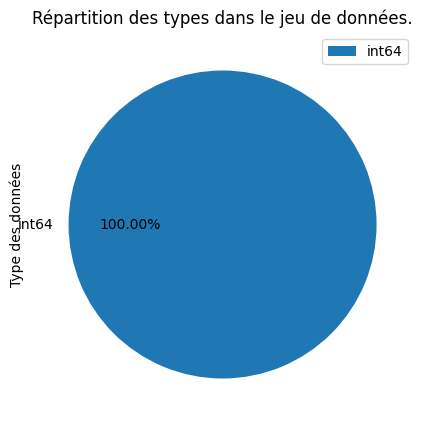


###### Les 5 premières et dernières lignes ######



,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2
2988180,123718,1508211379189330,1508211379000,2,233578,1508211543583,4,3,2,1,25,2



###### Nombre de valeurs uniques ######



,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,322897,1048594,646874,72,46033,2983198,3,5,8,11,28,7



###### Doublons génériques (toutes les variables sont utilisées) ######



np.int64(0)


###### Doublons sans l'index ######



np.int64(0)


###### Informations du taux de remplissage ######



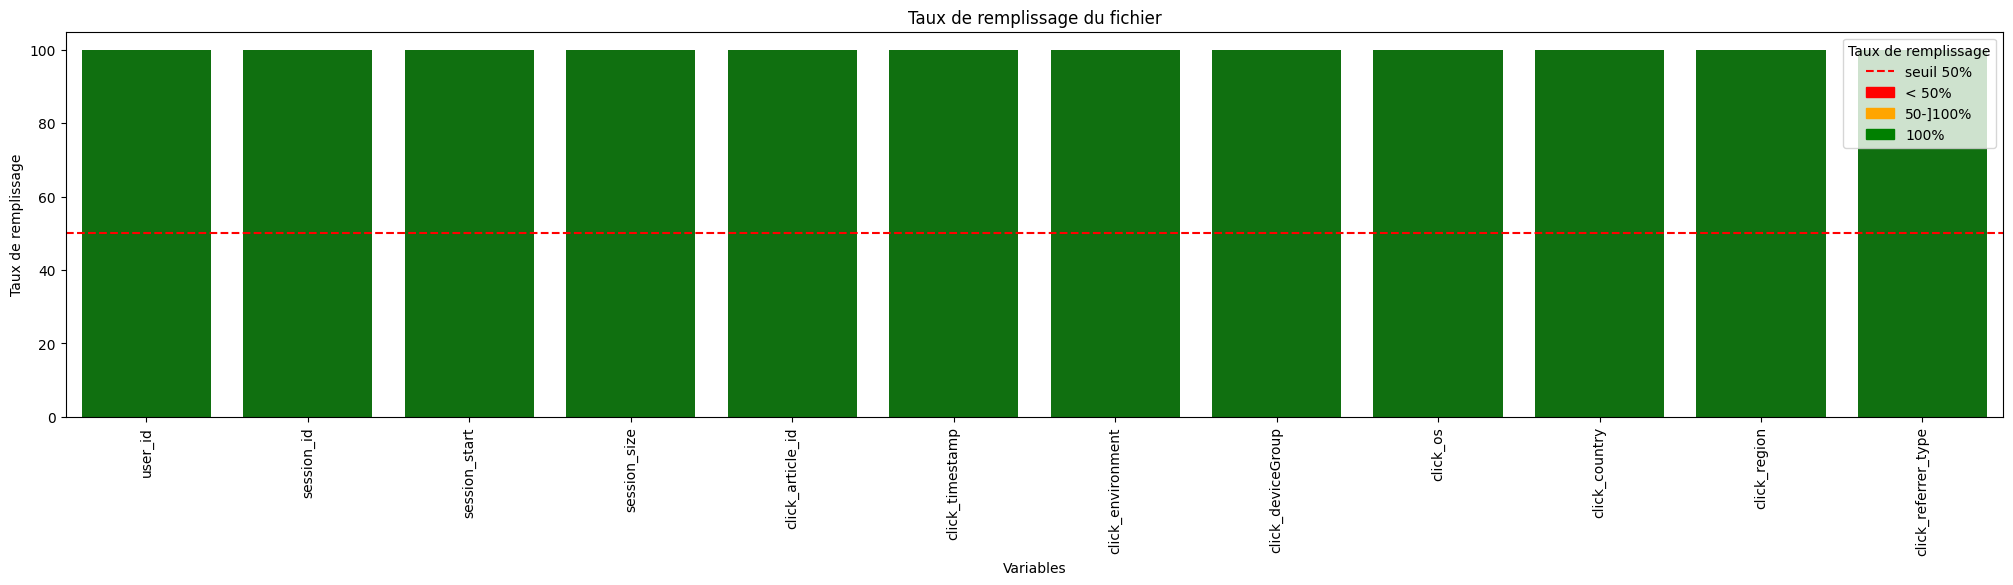


###### Statistiques descriptives ######



,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06
mean,1.079478e+05,1.507472e+15,1.507472e+12,3.901885e+00,1.949226e+05,1.507474e+12,3.942652e+00,1.819306e+00,1.327760e+01,1.357656e+00,1.831331e+01,1.838981e+00
std,8.364836e+04,3.855245e+11,3.855245e+08,3.929941e+00,9.076842e+04,3.858510e+08,3.396804e-01,1.042214e+00,6.881718e+00,1.725861e+00,7.064006e+00,1.156356e+00
min,0.000000e+00,1.506825e+15,1.506825e+12,2.000000e+00,3.000000e+00,1.506827e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.034100e+04,1.507124e+15,1.507124e+12,2.000000e+00,1.242280e+05,1.507127e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
50%,8.622900e+04,1.507493e+15,1.507493e+12,3.000000e+00,2.023810e+05,1.507495e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00
75%,1.632610e+05,1.507749e+15,1.507749e+12,4.000000e+00,2.770670e+05,1.507751e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00
max,3.228960e+05,1.508211e+15,1.508211e+12,1.240000e+02,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00



###### Boxplots des variables ######



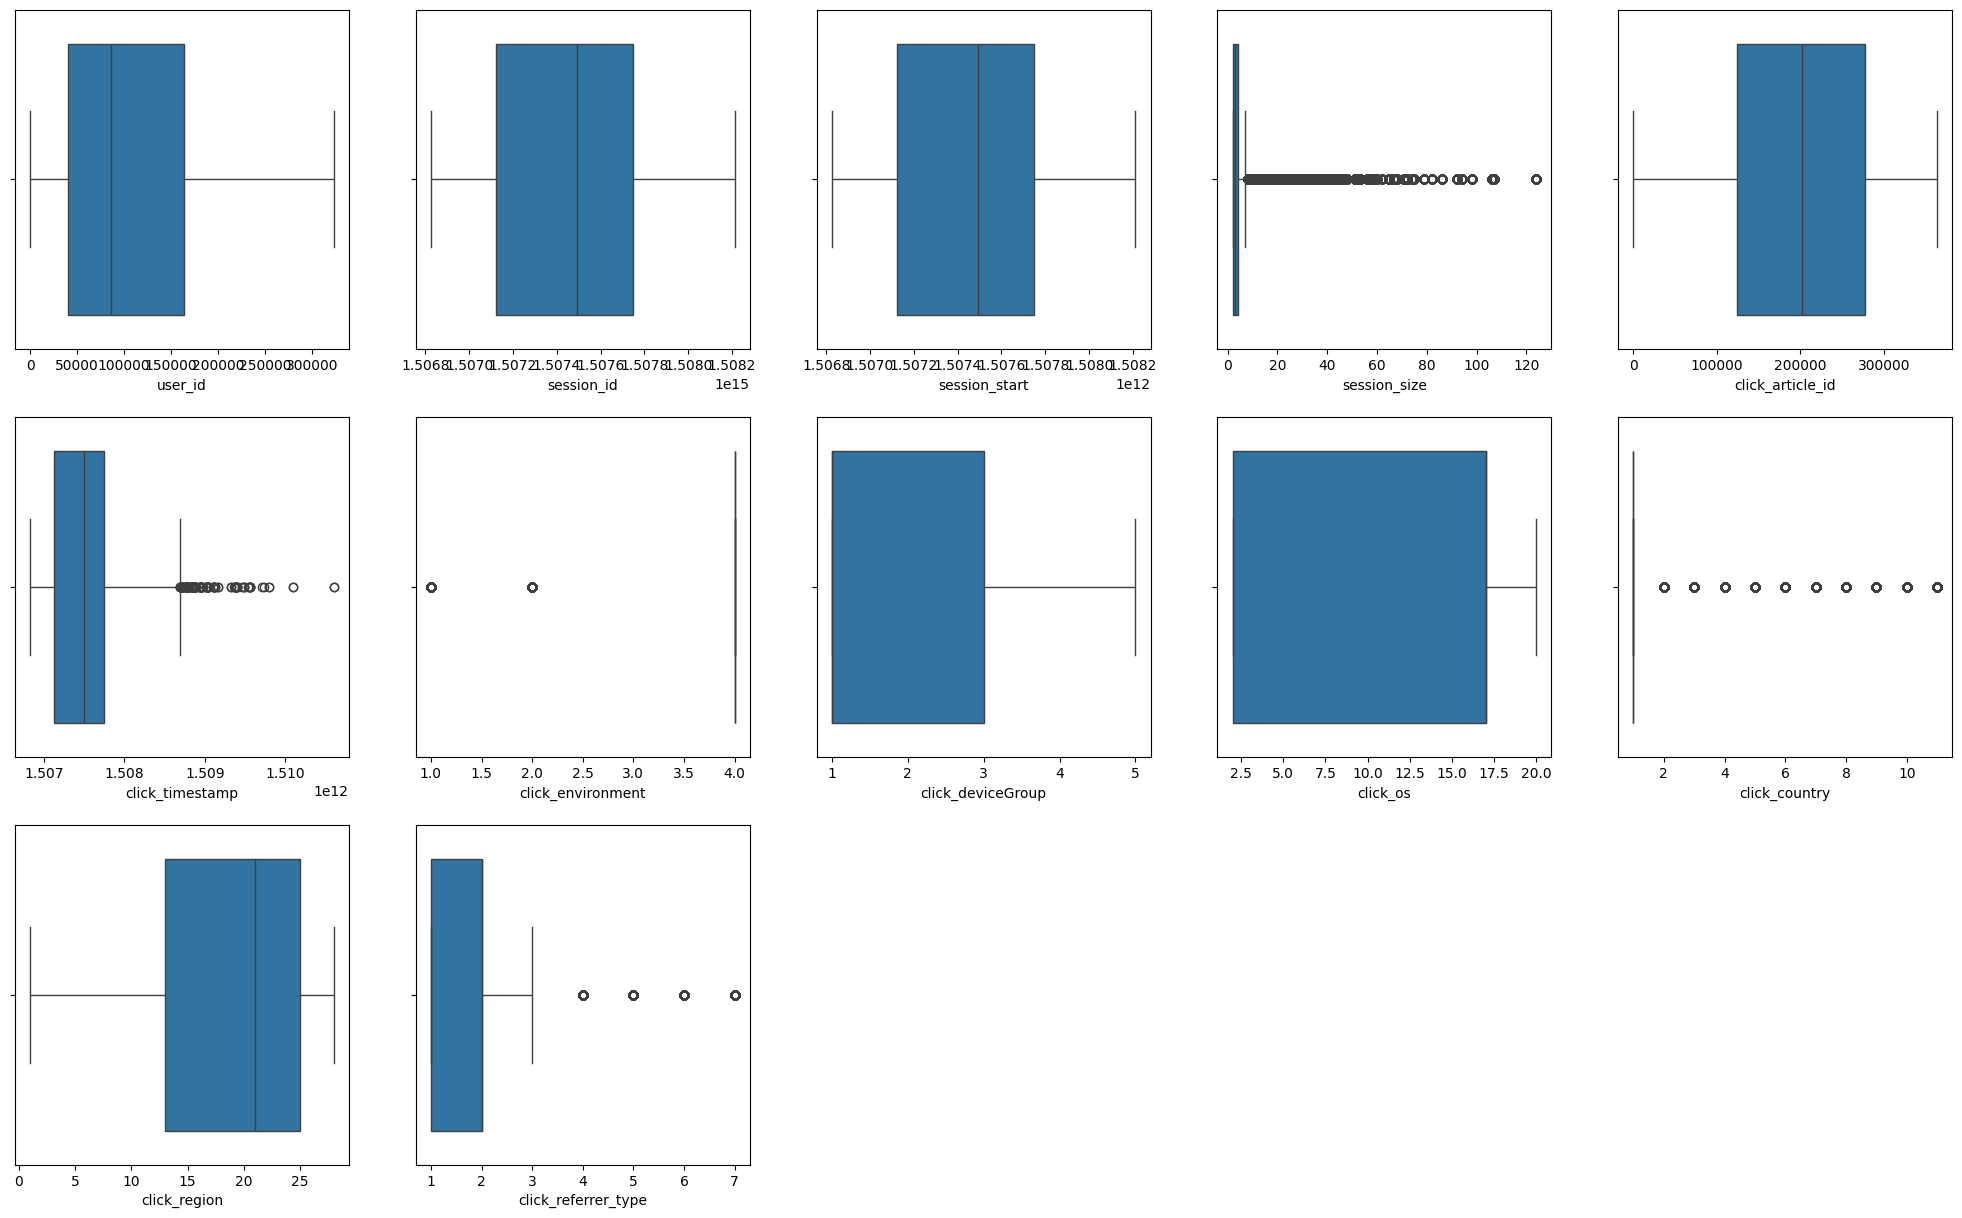

In [10]:
analyse_exploratoire_generique(df_clicks_hour)

### Full (fusion de articles et de cliques)


###### Informations générales ######

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 16 columns):
 #   Column               Dtype
---  ------               -----
 0   user_id              int64
 1   session_id           int64
 2   session_start        int64
 3   session_size         int64
 4   click_article_id     int64
 5   click_timestamp      int64
 6   click_environment    int64
 7   click_deviceGroup    int64
 8   click_os             int64
 9   click_country        int64
 10  click_region         int64
 11  click_referrer_type  int64
 12  category_id          int64
 13  created_at_ts        int64
 14  publisher_id         int64
 15  words_count          int64
dtypes: int64(16)
memory usage: 364.8 MB

###### Répartition des types dans le dataset ######

int64    16
Name: count, dtype: int64


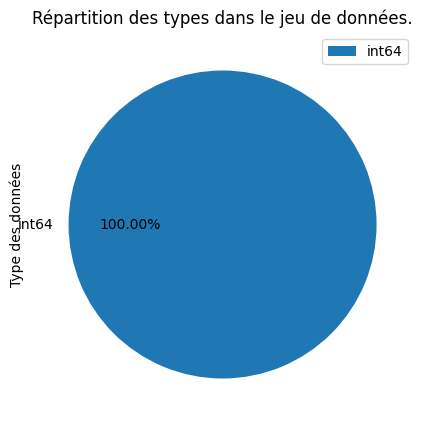


###### Les 5 premières et dernières lignes ######



,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,281,1506800518000,0,280
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,136,1506816482000,0,226
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,375,1506807839000,0,159
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,209,1506788025000,0,206
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,247,1506784316000,0,239


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1,174,1508187619000,0,171
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2,26,1508185091000,0,162
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2,281,1508236945000,0,370
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2,375,1508181572000,0,212
2988180,123718,1508211379189330,1508211379000,2,233578,1508211543583,4,3,2,1,25,2,375,1508176010000,0,174



###### Nombre de valeurs uniques ######



,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
0,322897,1048594,646874,72,46033,2983198,3,5,8,11,28,7,316,45785,1,536



###### Doublons génériques (toutes les variables sont utilisées) ######



np.int64(0)


###### Doublons sans l'index ######



np.int64(0)


###### Informations du taux de remplissage ######



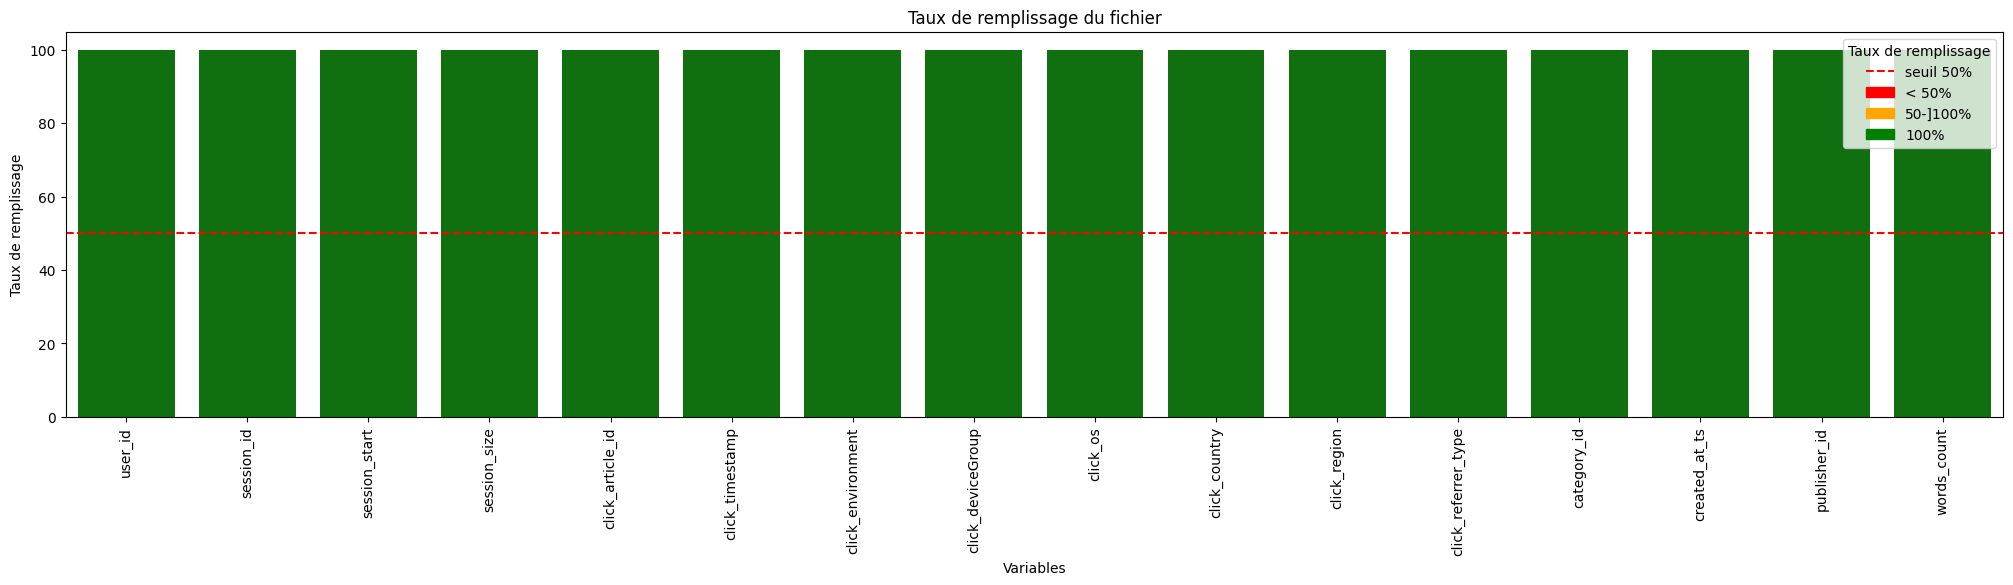


###### Statistiques descriptives ######



,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2988181.0,2.988181e+06
mean,1.079478e+05,1.507472e+15,1.507472e+12,3.901885e+00,1.949226e+05,1.507474e+12,3.942652e+00,1.819306e+00,1.327760e+01,1.357656e+00,1.831331e+01,1.838981e+00,3.059382e+02,1.506751e+12,0.0,2.086283e+02
std,8.364836e+04,3.855245e+11,3.855245e+08,3.929941e+00,9.076842e+04,3.858510e+08,3.396804e-01,1.042214e+00,6.881718e+00,1.725861e+00,7.064006e+00,1.156356e+00,1.130805e+02,7.068639e+09,0.0,8.160152e+01
min,0.000000e+00,1.506825e+15,1.506825e+12,2.000000e+00,3.000000e+00,1.506827e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.166573e+12,0.0,0.000000e+00
25%,4.034100e+04,1.507124e+15,1.507124e+12,2.000000e+00,1.242280e+05,1.507127e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.500000e+02,1.507053e+12,0.0,1.730000e+02
50%,8.622900e+04,1.507493e+15,1.507493e+12,3.000000e+00,2.023810e+05,1.507495e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,3.270000e+02,1.507403e+12,0.0,1.980000e+02
75%,1.632610e+05,1.507749e+15,1.507749e+12,4.000000e+00,2.770670e+05,1.507751e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,4.090000e+02,1.507717e+12,0.0,2.320000e+02
max,3.228960e+05,1.508211e+15,1.508211e+12,1.240000e+02,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,4.600000e+02,1.510666e+12,0.0,6.690000e+03



###### Boxplots des variables ######



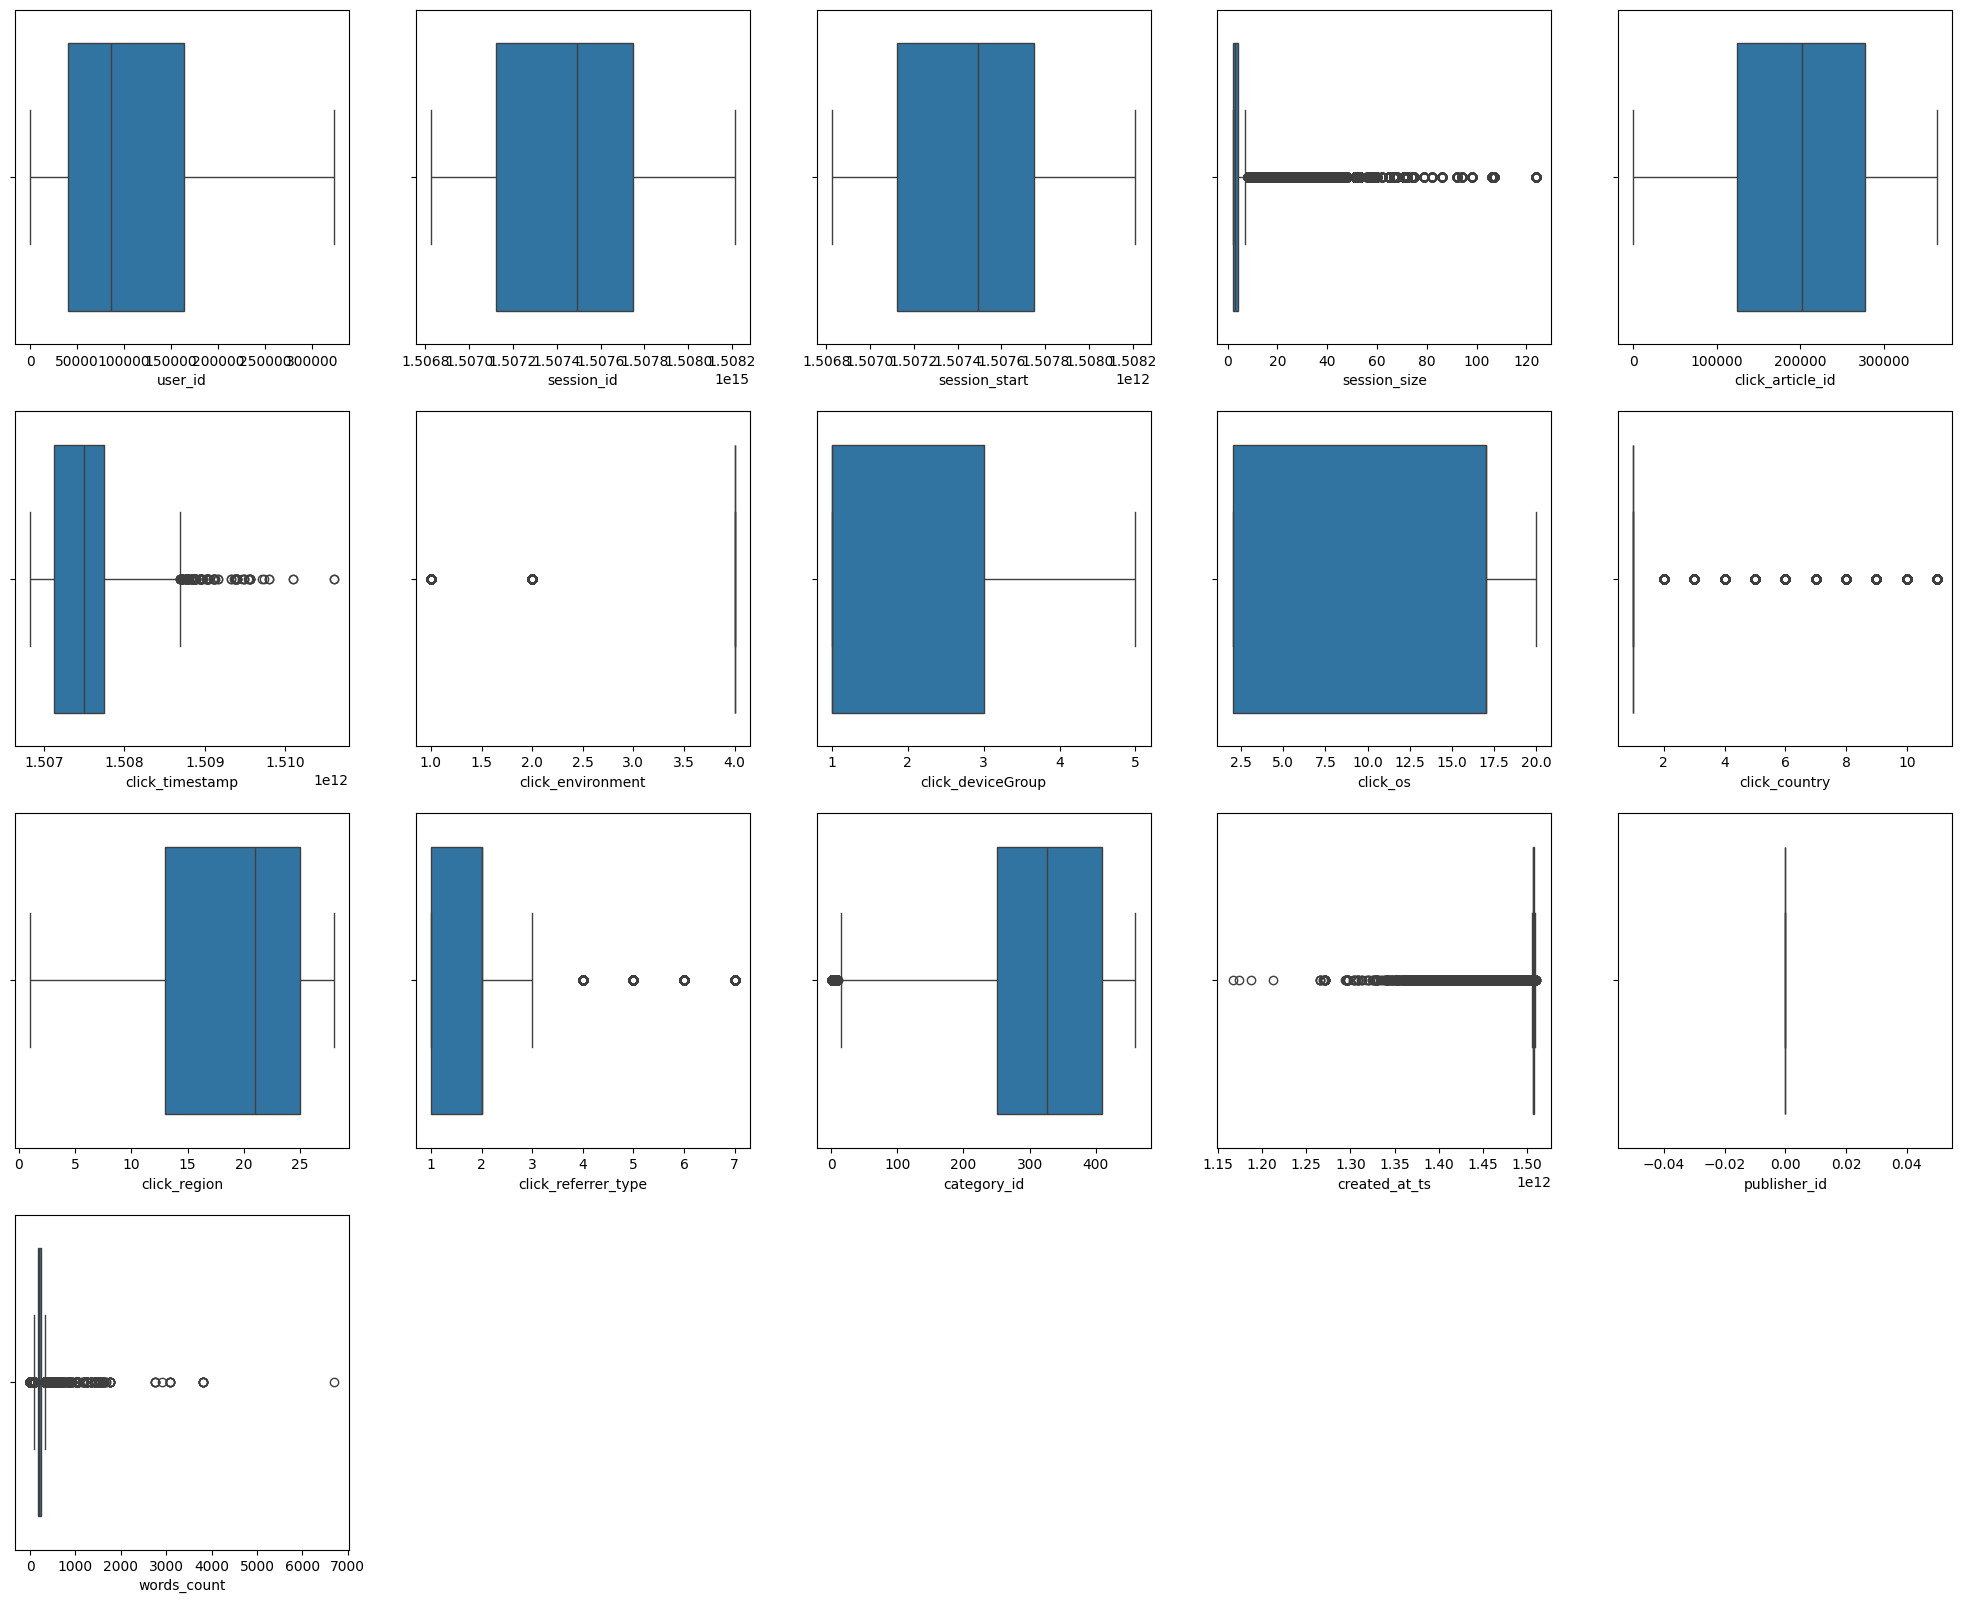

In [11]:
analyse_exploratoire_generique(df_full)


###### Informations générales ######

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 250 entries, 0 to 249
dtypes: float32(250)
memory usage: 347.2 MB

###### Répartition des types dans le dataset ######

float32    250
Name: count, dtype: int64


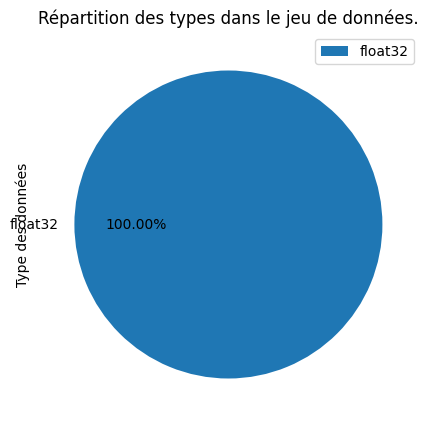


###### Les 5 premières et dernières lignes ######



,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,-0.581154,0.702346,-0.124813,...,-0.410549,0.564252,-0.463959,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,-0.136932,-0.995471,0.991298,0.031871,-0.915622,-0.658517,0.633090,-0.564356,0.676551,-0.446068,...,-0.681986,-0.574185,-0.536908,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691553,-0.588281,0.902999,0.124571,...,-0.162220,-0.242030,-0.476131,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,0.246004,0.255191,-0.329587,...,-0.422999,0.390324,0.655911,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726
364046,-0.257134,-0.994631,0.983792,-0.190975,-0.953720,-0.893823,0.708974,-0.557027,0.846842,-0.118519,...,-0.490481,-0.689666,-0.661846,0.490945,0.736525,0.667668,0.902130,0.983873,-0.838183,-0.179283



###### Nombre de valeurs uniques ######



,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,359463,277948,359896,358944,359878,360053,359599,359624,359981,359988,...,359756,360201,359803,359868,360064,359880,360128,359838,359706,359892



###### Doublons génériques (toutes les variables sont utilisées) ######



np.int64(2370)


###### Doublons sans l'index ######



np.int64(2370)


###### Informations du taux de remplissage ######



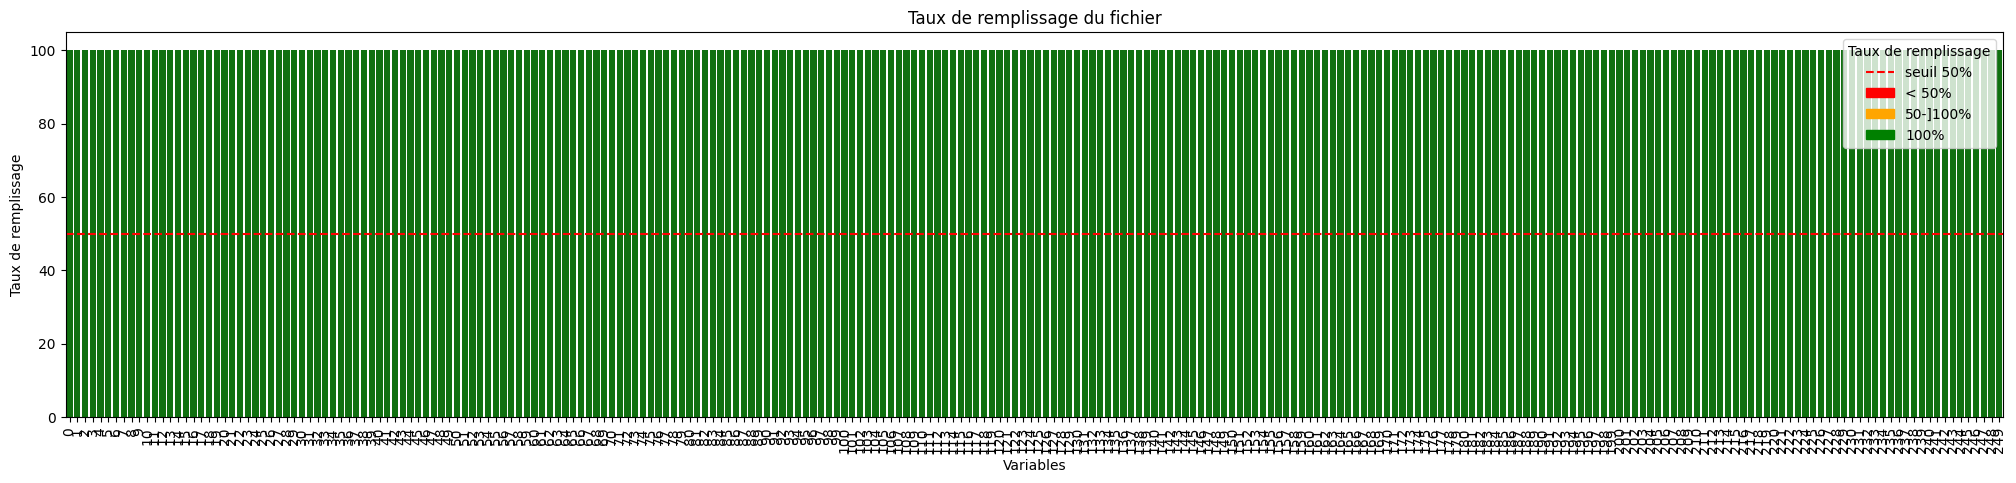

In [12]:
analyse_exploratoire_generique(df_embedding_articles, enable_analyse_outlier=False)

## Analyses

### Analyses univariés

#### Nombre d'utilisateurs

In [13]:
nb_user = df_full["user_id"].nunique()
print(f"Il y a {nb_user} utilisateurs uniques")

Il y a 322897 utilisateurs uniques


#### Nombres d'articles unique cliqués

In [14]:
nb_articles = df_full["click_article_id"].nunique()
print(f"Il y a {nb_articles} articles unique cliqués")

Il y a 46033 articles unique cliqués


#### Période entre le premier et le dernier clique

In [15]:
first_click = min(df_full["click_timestamp"])
last_click = max(df_full["click_timestamp"])

date_first_click = pd.to_datetime(first_click, unit="ms")
date_last_click = pd.to_datetime(last_click, unit="ms")

days_between_first_and_last_click = date_last_click - date_first_click

print(f"La date du premier clique est : {date_first_click}")
print(f"La date du dernier clique est : {date_last_click}")
print(f"Soit une période de {days_between_first_and_last_click}")

La date du premier clique est : 2017-10-01 03:00:00.026000
La date du dernier clique est : 2017-11-13 20:04:14.886000
Soit une période de 43 days 17:04:14.860000


#### Période entre le premier et le dernier article

In [16]:
first_article = min(df_full["created_at_ts"])
last_article = max(df_full["created_at_ts"])

date_first_article = pd.to_datetime(first_article, unit="ms")
date_last_article = pd.to_datetime(last_article, unit="ms")

print(f"La date du premier article est : {date_first_article}")
print(f"La date du dernier article est : {date_last_article}")

La date du premier article est : 2006-12-20 00:00:00
La date du dernier article est : 2017-11-14 13:26:54


### Analyses des interactions

#### Distribution de nombre de cliques par utilisateur

In [17]:
nb_clicks_per_user = df_full.groupby("user_id").size()
click_distribution = nb_clicks_per_user.value_counts().sort_values(ascending=False)
click_distribution

2      101428
4       38432
3       22660
6       20370
5       18070
        ...  
327         1
783         1
260         1
362         1
212         1
Name: count, Length: 302, dtype: int64

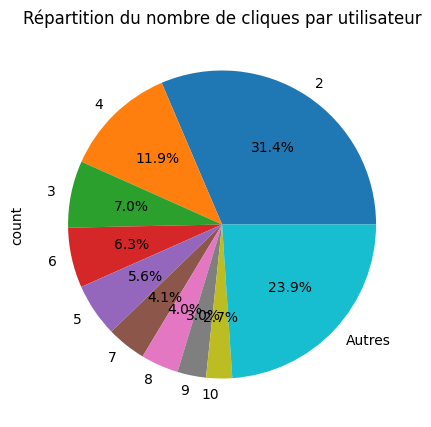

In [18]:
tops_click_distribution = click_distribution.head(9)
tops_click_distribution["Autres"] = click_distribution[9:].sum()
tops_click_distribution.plot(kind="pie", autopct="%1.1f%%", figsize=(5, 5), title="Répartition du nombre de cliques par utilisateur")
plt.show()

Il y a donc presque 75% d'utilisateurs ayant fait 10 cliques ou moins pour la période, nous avons donc affaire à une forte présence de nouveaux clients ou de clients occasionnels.

#### Distribution du nombre de cliques par articles

In [19]:
nb_clicked_per_article = df_full.groupby("click_article_id")["user_id"].count().sort_values(ascending=False)

In [20]:
nb_clicked_per_article_count = nb_clicked_per_article.value_counts()
nb_clicked_per_article_count.index.name = "nombre de cliques"
nb_clicked_per_article_count

nombre de cliques
1        24811
2         4682
3         2129
4         1315
5          990
         ...  
20303        1
21062        1
21577        1
21855        1
23122        1
Name: count, Length: 1185, dtype: int64

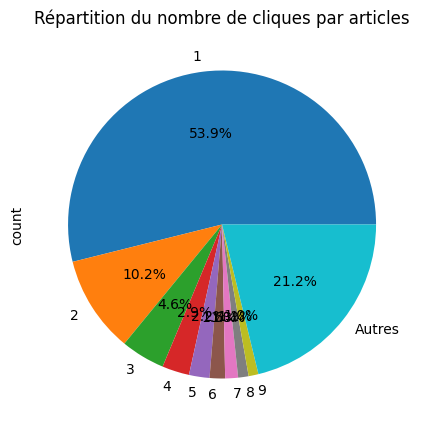

In [21]:
tops_nb_clicked_per_article_distribution = nb_clicked_per_article_count[:9]
tops_nb_clicked_per_article_distribution["Autres"] = nb_clicked_per_article_count[9:].sum()
tops_nb_clicked_per_article_distribution.plot(kind="pie", autopct="%1.1f%%", figsize=(5, 5), title="Répartition du nombre de cliques par articles") 
plt.show()

Un très grand nombre d'articles n'a été consulté qu'une seule fois, et une bonne partie d'articles ont été seulement consulté 9 fois au maximum pour la période donnée. La présence d'un grand nombre d'articles non populaires est par conséquent constatée.

#### Les 10 articles les plus populaires

In [22]:
most_popular_articles = pd.DataFrame(nb_clicked_per_article.head(10)).reset_index()
most_popular_articles = most_popular_articles.rename(columns={"user_id": "nombre de cliques"})
most_popular_articles["en pourcentage"] = most_popular_articles["nombre de cliques"].apply(lambda x : round(x/nb_clicked_per_article.sum()*100, 4))
most_popular_articles

,click_article_id,nombre de cliques,en pourcentage
0,160974,37213,1.2453
1,272143,28943,0.9686
2,336221,23851,0.7982
3,234698,23499,0.7864
4,123909,23122,0.7738
5,336223,21855,0.7314
6,96210,21577,0.7221
7,162655,21062,0.7048
8,183176,20303,0.6794
9,168623,19526,0.6534


#### Temps en jours entre la création de l'article et le clique d'un utilisateur

In [23]:
ages_days = (df_full["click_timestamp"] - df_full["created_at_ts"]) / 1000 / 86400
ages_days = ages_days.astype(int)
count_ages_days = ages_days.value_counts()

In [24]:
ages_days.describe()

count    2.988181e+06
mean     8.012232e+00
std      8.172807e+01
min     -2.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.940000e+03
dtype: float64

In [25]:
count_ages_days

0       2619049
1        239132
2         27093
3         12415
4          7354
         ...   
1851          1
3703          1
2121          1
2468          1
1693          1
Name: count, Length: 1809, dtype: int64

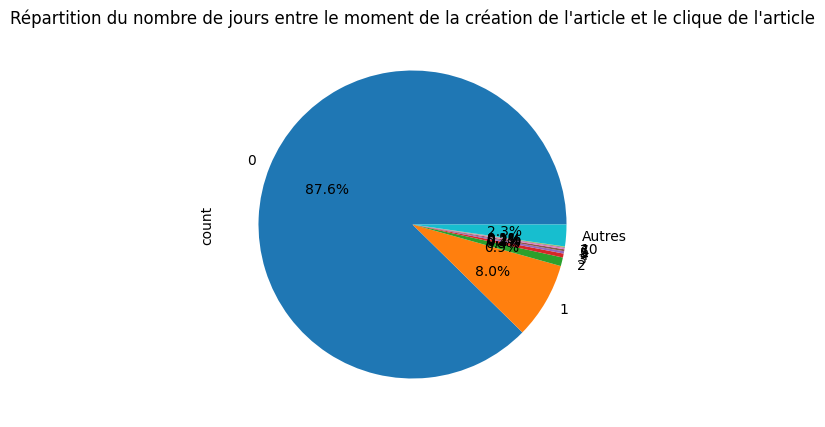

In [26]:
tops_count_ages = count_ages_days[:9]
tops_count_ages["Autres"] = count_ages_days[9:].sum()
tops_count_ages.plot(kind="pie", autopct="%1.1f%%", figsize=(5, 5), title="Répartition du nombre de jours entre le moment de la création de l'article et le clique de l'article")
plt.show()

Cette analyse mis en évidence un intérêt important pour les nouveaux articles, puisque que la très grande majorité des cliques se font en quelques heures après la création de l'article.

#### Couverture des articles

In [27]:
couverture_articles = round(len(nb_clicked_per_article) / len(df_embedding_articles) *100, 2)
print(f"{couverture_articles} % d'articles ont été cliqués")

12.64 % d'articles ont été cliqués


Cette faible couverture d'articles consultés pour la période renforce l'importance de l'âge des articles, les anciens articles sont peu, voire pas du tout consultés.

### Performances des différentes recommandations

#### Taille des fichiers des datasets

In [28]:
conversion = 1024*1024
mem_articles_embeddings = os.path.getsize(DATASETS_PATH + "articles_embeddings.pickle") / conversion
mem_clicks_hour_concatenated = os.path.getsize(DATASETS_PATH + "clicks_hour_concatenated.csv") / conversion

print(f"Taille du fichier articles_embeddings.pickle : {mem_articles_embeddings:.2f} Mo")
print(f"Taille du fichier clicks_hour_concatenated : {mem_clicks_hour_concatenated:.2f} Mo")


Taille du fichier articles_embeddings.pickle : 347.18 Mo
Taille du fichier clicks_hour_concatenated : 213.16 Mo


Ces deux fichiers ont une taille de fichiers assez conséquents, il serait probablement nécessaire d'opter une solution de réduction de mémoire

#### 1ère version non optimisée

##### Temps exécution

###### most_popular

In [29]:
%%time

recommender.most_popular_articles(df_clicks_hour)

CPU times: total: 15.6 ms
Wall time: 22.5 ms


click_article_id
160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
Name: count, dtype: int64

###### best_cosine_similar

In [30]:
%%time

recommender.best_cosine_similar_articles_per_user(5, df_clicks_hour, df_embedding_articles)

CPU times: total: 219 ms
Wall time: 369 ms


160765    0.814084
149976    0.798555
149529    0.794770
161846    0.791991
162714    0.791854
dtype: float32

###### best_svds_preds

In [31]:
%%time

recommender.best_preds_svds_user(24, df_clicks_hour)

CPU times: total: 172 ms
Wall time: 495 ms


click_article_id
225010    0.132694
207122    0.132480
156381    0.128120
160974    0.127953
58619     0.126919
Name: 24, dtype: float64

###### hybride

In [32]:
%%time

recommender.hybrid_recommender(24, df_clicks_hour, df_embedding_articles)

CPU times: total: 4.33 s
Wall time: 10.8 s


('hybrid',
 click_article_id
 158915    0.744148
 207122    0.743986
 157798    0.636029
 156381    0.633296
 208150    0.566667
 dtype: float64)

###### Conclusion

Bien que la pulpart des systèmes de recommandations produisent un temps de calcul raisonnable, il y a deux éléments risquent de poser problèmes :

1) ce sont des fonctions qui nécessitent la lecture des deux fichiers : clicks_hour et articles_embeddings, et comme nous avons pu constater, ils sont assez volumineux. Cela risque de poser problème avec l'architecutre function azure/blob storage qui nécessite le téléchargement des fichiers à chaque appel, donc environ 550 mo par appel.
2) Azure functions est un service azure et non un serveur, par conséquent, plus une fonction utilise des ressources, plus elle est coûteuse, ce qui est problématique pour les fonctions non optimisées, surtout celle de hybride qui prend 10 secondes pour un seul appel !

Il est donc nécessaire d'opter à des techniques de réductions de taille et d'optimisations.

#### 2ème version, avec optimisation

##### Préparation des fichiers nécessaires

###### Dataset Articles embeddings

Nous avons constaté que la couverture des articles est assez faible, un grand nombre d'articles n'intéressent pas donc, par conséquent, on élimine les articles superflus, et on applique une réduction de dimension par PCA afin de réduire encore plus la taille

In [33]:
if os.path.isfile(PCA_REDUCTED_ARTICLES_EMBEDDINGS_PATH):
    # Récupère le dataset si déjà enregistré
    df_pca_reducted_articles_embeddings = pd.read_pickle(PCA_REDUCTED_ARTICLES_EMBEDDINGS_PATH)
else:
    # Obtenir le dataset réduit
    df_pca_reducted_articles_embeddings = prepare_files.pca_reduct_articles_embeddings(df_embedding_articles, df_clicks_hour)
    df_pca_reducted_articles_embeddings.to_pickle(PCA_REDUCTED_ARTICLES_EMBEDDINGS_PATH)

In [34]:
mem_pca_reducted_articles_embeddings = os.path.getsize(PCA_REDUCTED_ARTICLES_EMBEDDINGS_PATH) / conversion
print(f"Taille du fichier réduit : {mem_pca_reducted_articles_embeddings:.2f} Mo")

Taille du fichier réduit : 9.48 Mo


###### Dataset clicks_hour

Le dataset clicks_hour contient de nombreuses données inutilisées, ce qui entraîne un gaspillage de ressources.
Il est donc pertinent de créer un dataset synthétisant les informations les plus importantes, à savoir :

- L’identifiant de l’utilisateur
- Le nombre de clics effectués par l’utilisateur
- Le dernier article consulté par l’utilisateur

In [35]:
df_clicks_essentials_informations = prepare_files.clicks_essentials_informations(df_clicks_hour)
df_clicks_essentials_informations.to_pickle(CLICKS_ESSENTIALS_INFORMATIONS_PATH)

In [36]:
mem_clicks_essentials_informations = os.path.getsize(CLICKS_ESSENTIALS_INFORMATIONS_PATH) / conversion
print(f"Taille du fichier : {mem_clicks_essentials_informations:.2f} Mo")

Taille du fichier : 7.39 Mo


###### Dataset SVDS

La recommandations type collaborative Filtering utilise SVDS pour produire les prédictions des articles recommandés, et pour qu'elle soit utilisable, il est nécessaire qu'on calcule tous les interactions utilisateurs-articles, cela pose donc deux problèmes suivants :

1) si à chaque appel, on doit recalculer le svds (qui est assez coûteux en ressources), cela devient donc très redondant et assez gourmand en ressources, il est donc préférable de ne le calculer qu'une seule fois et de lire le résultat à chaque fois qu'on fait appel à la collaborative filtering.
Ensuite de décider une mise à jour périodique.
2) le nombre de cellules pour un SVDS est un produit, et dans ce projet, on a 322897 utilisateurs * 46033 articles consultés, ce qui fait exactement ... 14 863 917 601, soit 14 milliards de données, ce qui n'est pas possible bien évidemment.
Il est donc nécessaire de limiter les utilisateurs et les articles afin de ne conserver que les données les plus intéressantes, soit les utilisateurs les plus actifs et les articles les plus populaires
Arbitrairement, un filtre a été appliqué : seuls les utilisateurs ayant au moins de 10 cliques, et les articles ayant été cliqués d'au moins de 100 fois sont conservés.

In [37]:
df_svds = prepare_files.preds_svds_user(df_clicks_hour)
df_svds.to_pickle(SVDS_PATH)

In [38]:
print(f"Dimensions de SVDS : {df_svds.shape}")
print(f"Le dataset SVDS contient : {df_svds.shape[0] * df_svds.shape[1]} cellules")

Dimensions de SVDS : (1138, 8832)
Le dataset SVDS contient : 10050816 cellules


In [39]:
mem_svds = os.path.getsize(SVDS_PATH) / conversion
print(f"Taille du fichier : {mem_svds:.2f} Mo")

Taille du fichier : 76.76 Mo


###### Dataset Hybride 

##### Test d'exécutions de fonctions

Exécution de la recommandation avec le dataset embeddings articles réduits.

In [40]:
%%time

recommender.hybrid_recommender(24, df_clicks_hour, df_pca_reducted_articles_embeddings)

CPU times: total: 672 ms
Wall time: 1.72 s


('hybrid',
 click_article_id
 158915    0.746287
 207122    0.732210
 157798    0.631904
 156381    0.603642
 208150    0.552364
 dtype: float64)

La différence est flagarente, presque 10 fois plus rapide

Exécution de la recommandation avec la version rapide (en utilisant des datasets précalculés)

In [41]:
# Génère et crée un fichier most_popular_articles
df_most_popular_articles = prepare_files.most_popular_articles(df_clicks_hour)
df_most_popular_articles.to_pickle(MOST_POPULAR_ARTICLES_PATH)

In [42]:
%%time

recommender.fast_hybrid_recommender(-1, df_most_popular_articles, df_clicks_essentials_informations, df_svds, df_pca_reducted_articles_embeddings)

CPU times: total: 0 ns
Wall time: 4 ms


('most_popular',
 click_article_id
 160974    37213
 272143    28943
 336221    23851
 234698    23499
 123909    23122
 Name: count, dtype: int64)

In [43]:
%%time

recommender.fast_hybrid_recommender(5, df_most_popular_articles, df_clicks_essentials_informations, df_svds, df_pca_reducted_articles_embeddings)

CPU times: total: 0 ns
Wall time: 24.5 ms


('content based filtering',
 38187     0.772347
 156332    0.748798
 157315    0.746521
 83890     0.738626
 153323    0.734223
 dtype: float32)

Le content based filtering est quasi instanté !

In [44]:
%%time

recommender.fast_hybrid_recommender(24, df_most_popular_articles, df_clicks_essentials_informations, df_svds, df_pca_reducted_articles_embeddings)

CPU times: total: 547 ms
Wall time: 1.2 s


('hybrid',
 click_article_id
 158915    0.746287
 207122    0.732210
 157798    0.631904
 156381    0.603642
 208150    0.552364
 dtype: float64)

Même s'il n'y a pas une vraie grande différence entre cette fonction de recommandation et celle sans les datasets pré calculés, cette fonction reste tout de même 2 fois plus rapide au niveau de calcul CPU, ce qui constitue une bonne économie en ressources.
Sans oublier que les datasets précalculés occupent une espace mémoire bien plus légère